<a href="https://colab.research.google.com/github/nargesalavi/Quantum-Open-Source-Foundation-Mentorship/blob/master/QNN_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Quantum Neural Network for State Approximation

In this task, the below neural network is trained to approximate a random quantum state. The aim is to investigate the effect of number of layers in the accuracy of the approximation.

<center><img src = "Figures/qnn.png" style = "width:400px"/><figcaption><center>Figure 1<figcaption>

<center><img src = "Figures/layers.png" style = "width:400px"/><figcaption><center>Figure 2<figcaption>

In this project, I use Cirq and Tensorflow Quantum to implement the models.

In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install tensorflow-quantum

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s "/content/gdrive/My Drive" "/content/mydrive"

ln: failed to create symbolic link '/content/mydrive/My Drive': Input/output error


In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

In [62]:
qubits = cirq.GridQubit.rect(1, 4)

The two following function builds the even and odd layers using parameterized gates.

In [2]:
def generate_even_block(block_number,types = 1):
    """ Function for generating the even blocks
        Arguments:
          block_number: Block number, it has to be even.
          types: It determines the type of block. If it is 1, Figure 2 block is generated.
                 If it is 2 Figure 3, the bonus part, block are generated.
                 Its default value is 1.
        return: ciq.Circuit """
    if (types == 1):
        params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

        # create the parameterized circuit
        circuit = cirq.Circuit(
            cirq.rz(params[0])(qubits[0]),
            cirq.rz(params[1])(qubits[1]),
            cirq.rz(params[2])(qubits[2]),
            cirq.rz(params[3])(qubits[3]),
            cirq.CZ(qubits[0],qubits[1]),
            cirq.CZ(qubits[0],qubits[2]),
            cirq.CZ(qubits[0],qubits[3]),
            cirq.CZ(qubits[1],qubits[2]),
            cirq.CZ(qubits[1],qubits[3]),
            cirq.CZ(qubits[2],qubits[3])
        )
    elif(types == 2):
        params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*8,block_number*8)])
        
        circuit = cirq.Circuit(
            cirq.ry(params[0])(qubits[0]),
            cirq.ry(params[1])(qubits[1]),
            cirq.ry(params[2])(qubits[2]),
            cirq.ry(params[3])(qubits[3]),
            cirq.CNOT(qubits[3], qubits[2]) ** params[4],
            cirq.CNOT(qubits[0], qubits[3]) ** params[5],
            cirq.CNOT(qubits[1], qubits[0]) ** params[6],
            cirq.CNOT(qubits[2], qubits[1]) ** params[7]
        )
    else:
        print("Only types 1 and 2 are supported!")
        return cirq.Circuit()
    return circuit

In [3]:
def generate_odd_block(block_number, types = 1):
    """ Function for generating the odd blocks
        block_number: Block number, it has to be odd.
        types: It determines the type of block. If it is 1, Figure 2 block is generated; 
               If it is 2 Figure 3,the bonus part, block are generated.
               Its default value is 1.
        return: ciq.Circuit """
    if (types == 1):
        params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

        # create the parameterized circuit
        circuit = cirq.Circuit(
            cirq.rx(params[0])(qubits[0]),
            cirq.rx(params[1])(qubits[1]),
            cirq.rx(params[2])(qubits[2]),
            cirq.rx(params[3])(qubits[3])
        )
    elif(types == 2):
        params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*8,block_number*8)])
        
        circuit = cirq.Circuit(
            cirq.ry(params[0])(qubits[0]),
            cirq.ry(params[1])(qubits[1]),
            cirq.ry(params[2])(qubits[2]),
            cirq.ry(params[3])(qubits[3]),
            cirq.CNOT(qubits[3], qubits[0]) ** params[4],
            cirq.CNOT(qubits[2], qubits[3]) ** params[5],
            cirq.CNOT(qubits[1], qubits[2]) ** params[6],
            cirq.CNOT(qubits[0], qubits[1]) ** params[7]
        )
    else:
        print("Only types 1 and 2 are supported!")
        return cirq.Circuit()
    
    return circuit

This function builds the quantum neural network by using the previous generating block functions.

In [4]:
def generate_qnn(l,types = 1 ):
    """ Function for generating qnn, containing l number of layers.
        Arguments:
          l: number of layers, each layer contains one odd and one even block.
        return: ciq.Circuit """
    circuit = cirq.Circuit()
    for i in range(1,2*l+1):
        if i % 2 == 1:
            circuit += generate_odd_block(i,types = types)
        else:
            circuit += generate_even_block(i,types = types)
        
    return circuit

You can see the QNN, which has one layer, below. Additionally, you can find how the parameters are defined and initialized. For calculating the state of the qnn circuit, I use tfq.layers.State() from TensorFlow Quantum (TFQ).

In [ ]:
l=1
qnn = generate_qnn(l)
print(qnn)

# Defining and Initializing the parameters:
params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32) #tf.zeros([1,8*l ], tf.float32)
print('Parameters:\n', params)
params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])

# Calculating the state vector:
state_layer = tfq.layers.State()
state = state_layer(qnn, symbol_names=params_names, symbol_values=params)
print(state)

                                               ┌──┐
(0, 0): ───Rx(theta_0)───Rz(theta_4)───@───@────@─────────────
                                       │   │    │
(0, 1): ───Rx(theta_1)───Rz(theta_5)───@───┼────┼@────@───────
                                           │    ││    │
(0, 2): ───Rx(theta_2)───Rz(theta_6)───────@────┼@────┼───@───
                                                │     │   │
(0, 3): ───Rx(theta_3)───Rz(theta_7)────────────@─────@───@───
                                               └──┘
Parameters:
 tf.Tensor(
[[4.5707154  3.8129761  0.2682257  1.5909367  0.45797044 0.3628921
  0.48399717 2.9613216 ]], shape=(1, 8), dtype=float32)
Instructions for updating:
reduction_indices is deprecated, use axis instead
<tf.RaggedTensor [[(-0.07982996106147766-0.1266840100288391j), (0.11256241053342819-0.10331031680107117j), (-0.020141249522566795+0.0015802329871803522j), (0.005270978435873985+0.01992892101407051j), (0.42067328095436096-0.08501294255256653j), (-0.162296

Now, the target state, which the qnn will be trained to approximate, is randomly chosen.

In [ ]:
""" cirq.testing.random_circuit is used to generate a random state. The loop is for making sure that all
    the four qubits are involved in random generation."""
while True:
    random_circuit = cirq.testing.random_circuit(qubits = qubits,n_moments = np.random.randint(low=1,high=5),\
                                                                op_density = 0.99999999)
    target_state = tfq.layers.State()(random_circuit)
    
    if target_state[0].shape == 16:
        break

print(random_circuit)
print(target_state)

(0, 0): ───S───────iSwap───
                   │
(0, 1): ───Y───T───iSwap───

(0, 2): ───────Z───×───────
                   │
(0, 3): ───X───T───×───────
<tf.RaggedTensor [[(-1.910685465164705e-15+0j), (-1.3510585260894325e-15-1.3510586319685509e-15j), (3.090862321641907e-08-3.090861255827804e-08j), 0j, (-1.3510585260894325e-15-1.3510586319685509e-15j), (2.117582368135751e-22-1.910685253406468e-15j), (4.371138828673793e-08+8.881784197001252e-15j), 0j, (-3.0908619663705394e-08+3.0908616110991716e-08j), (-4.371138828673793e-08-5.329070518200751e-15j), (2.682209014892578e-07-0.9999999403953552j), 0j, 0j, 0j, 0j, 0j]]>


The following function, calculate the distance between the state vector of the qnn model $|\psi(\theta)>$  and the target state $|\varphi>$:

$\epsilon = min_\theta ||\quad|\psi(\theta)> - |\varphi> ||$.



In [41]:
def states_distance(state,target, distance_type = 1):
  """ This function calculates the distatnce between state and target by multipltying their differences to
    their conjugates. It is calculated by tf.tensordot with axes = 1, which does the same function as sum
    over all elements of the result of the muliplication of state and target.
    state:  The state vector of the model.
    target: The target state that the aim is to approximate it.
    distance_type: It determines the type of distance value. Its default value is 1.
                   For 1, || |state> - |target> ||^2
                   for 2, 1 - | <target|state> |^2
    return: Tensor of float of distance value."""
  if distance_type == 1:
    diff = state[0] - target[0]
    return np.sum(np.conjugate(diff.numpy()) * diff.numpy()).real
  elif distance_type == 2:
    state_overlap = np.sum(np.conjugate(target[0].numpy()) * state[0].numpy())
    return 1.0 - np.sum(np.conjugate(state_overlap) * state_overlap).real
  elif distance_type == 3:
    target_amplitudes = (np.conjugate(target[0].numpy()) * target[0].numpy()).real
    state_amplitudes = (np.conjugate(state[0].numpy()) * state[0].numpy()).real

    target_amplitudes[0] = 1 - np.sum(target_amplitudes[1:])
    state_amplitudes[0] = 1 - np.sum(state_amplitudes[1:])

    kl = tf.keras.losses.KLDivergence()
    

    return kl(target_amplitudes, state_amplitudes).numpy()

## Stochastic Gradient Descent:
To find the parameters, that minimize the distance between the output of the QNN and the target state, stochastic gradient descent method is used.

#### Gradients
In the following function, gradient of the *state_distance* function. It returns a list of partial derivative of *state_distance* w.r.t parameters of rotation gates. Partial derivatives are calculated with either numerical gradients or parameter shift rule.

In [42]:
def custom_gradient(params, target_state, parameter_shift = False, h = np.pi/2, distance_type = 1):
  """ This function calculates the gradients of the quantum circuit's parameters 
      using two methods: Parameter shift rules or Numerical differentiation.
      In numerical differentiation method, for Pauli gates the shift value is pi/2 and the ratio is 1/2. 
      Arguments:
        params: circuit's parameters, of which the gradient is calculated.
        target_state: The target state, which the quantum NN trys to approximate.
        parameter_shift: Determine which method is used to calculate the gradients. 
                         When it is True, the function uses parameter shift otherwise it uses numerical differentiation.
        h: The shift value for parameter. When parameter shift method is used, it is pi/2.
        distance_type: It determines the type of distance in states_distance function.
        return: list of gradients of distance function, defined above. """
  param_length = len(params[0])
  grad = np.zeros((param_length,), dtype=np.float32)
  if parameter_shift : 
    r = 1/2
    h = np.pi/2
  else:
    r = 1/(2*h)
  for i in range(param_length):
    
    params_plus_h = tf.convert_to_tensor([np.concatenate((params[0][0:i],[params[0][i]+h],params[0][i+1:]))])
    params_minus_h = tf.convert_to_tensor([np.concatenate((params[0][0:i],[params[0][i]-h],params[0][i+1:]))])
    state_plus_h = state_layer(qnn, symbol_names=params_names, symbol_values=params_plus_h)
    state_minus_h = state_layer(qnn, symbol_names=params_names, symbol_values=params_minus_h)
    #print('i', i, 'state_plus_h:', state_plus_h, 'state_minus_h:', state_minus_h) 
    grad[i] = r*(states_distance(state_plus_h,target_state,distance_type)-states_distance(state_minus_h,target_state,distance_type))

  return grad

#### Updating Parameters
Getting the parameters, the gradient, and the learning rate, the following function update the paramters.

In [5]:
def update_params(params, gradients, learning_rate):
  """ This function update parameters for stachastic gradient descent.
    params: Tensor of parameters that will be updated.
    gradients: Tensor of gradients of distance function.
    learning rate: The rate that parameters are updated.
    return: Tensor of updated paramters."""

  params -= learning_rate*gradients
  return params


In [69]:
L = 6
lr0 = 0.4
number_of_iteration = 1500
print_step = 100
lr_increase = 50
learning_rate = 0.1
number_of_rounds = 3

In [90]:
print(1.0e-3)

0.001


In [91]:
list_of_e =[]
types = 1
distance_type = 1
for round in range(number_of_rounds):
  while True:
      random_circuit = cirq.testing.random_circuit(qubits = qubits,n_moments = np.random.randint(low=1,high=5),\
                                                                  op_density = 0.99999999)
      target_state = tfq.layers.State()(random_circuit)
      
      if target_state[0].shape == 16:
          break
  print('########## Round:', round, '##########')
  print('########## Target State:', target_state, '##########')
  for l in range(1,L+1):
    print('***** Round:', round, '. Number of Layers:' , l, '*****')
    qnn = generate_qnn(l, types)
    params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) 
    params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
    eValues = []
    for i in range(number_of_iteration):
      learning_rate = lr0/(1 + (i//lr_increase))
      params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/16, distance_type = distance_type)

      params = update_params(params, params_grads,learning_rate)
      
      approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
      e = states_distance(approximation,target_state,distance_type)
      if (0<i and e<1.0e-3 and abs(eValues[-1] - e) < 1.0e-7):
        break
      eValues.append(e)

      if i % print_step == 0:
        print(' Iteration Number:', i, ', Distance:', e)
    print('---Training qnn with ', l, ' layers finished after', i,'iterations,Final distance =', e,'.')
    np.savetxt('/content/mydrive/model1_layer_{}_targetround{}'.format(l,round), eValues, delimiter='\n')
    prev_state = target_state

print('Training finished.')

########## Round: 0 ##########
########## Target State: <tf.RaggedTensor [[(3.0908619663705394e-08+3.4935488509512617e-15j), (-1.4174031548463972e-07+0.7071067690849304j), (3.0908619663705394e-08+5.40423410435773e-15j), (-1.85451710876805e-07+0.7071067690849304j), (-1.3510585260894325e-15-1.3510586319685509e-15j), (3.090862321641907e-08-3.090861255827804e-08j), (-1.3510585260894325e-15-1.3510586319685509e-15j), (3.090862321641907e-08-3.090861255827804e-08j), (3.0908619663705394e-08+4.8446074829198126e-15j), 0j, (3.0908619663705394e-08+6.755292736326281e-15j), 0j, (-1.351058420210314e-15-1.3510587378476693e-15j), 0j, (-1.351058420210314e-15-1.3510587378476693e-15j), 0j]]> ##########
***** Round: 0 . Number of Layers: 1 *****
 Iteration Number: 0 , Distance: 1.998587
 Iteration Number: 100 , Distance: 0.00030748494
---Training qnn with  1  layers finished after 145 iterations,Final distance = 6.2463494e-07 .
***** Round: 0 . Number of Layers: 2 *****
 Iteration Number: 0 , Distance: 1.58

In [ ]:
list_of_e =[]
types = 1
distance_type = 1
print(target_state)
for l in range(1,L+1):
  print('***** Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) 
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
  eValues = []
  variances = []
  for i in range(number_of_iteration):
    #learning_rate = lr0/(1 + (i//lr_increase))
    params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/16, distance_type = distance_type)
    grads_variance = np.var(params_grads)
    variances.append(grads_variance)

    if grads_variance < 0.00001:
      print('Training stopped after', i, 'iterations. Model reached the barren plateau.')
      break

    params = update_params(params, params_grads,learning_rate)
    
    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state,distance_type)
    eValues.append(e)

    if i % print_step == 0:
      print('Iteration Number:', i, ', Distance:', e)
  print('---Training qnn with ', l, ' layers finished.','Final distance =', e,'.')
  print(' State approximation: ', approximation)
  np.savetxt('/content/mydrive/model1_layer_{}'.format(l), eValues, delimiter='\n')
  np.savetxt('/content/mydrive/model1_variance_barren{}'.format(l), variances, delimiter='\n ')
  list_of_e.append(eValues)
print('Training finished.')

<tf.RaggedTensor [[(-1.910685465164705e-15+0j), (-1.3510585260894325e-15-1.3510586319685509e-15j), (3.090862321641907e-08-3.090861255827804e-08j), 0j, (-1.3510585260894325e-15-1.3510586319685509e-15j), (2.117582368135751e-22-1.910685253406468e-15j), (4.371138828673793e-08+8.881784197001252e-15j), 0j, (-3.0908619663705394e-08+3.0908616110991716e-08j), (-4.371138828673793e-08-5.329070518200751e-15j), (2.682209014892578e-07-0.9999999403953552j), 0j, 0j, 0j, 0j, 0j]]>
***** Number of Layers: 1 *****
Iteration Number: 0 , Distance: 1.979776
Iteration Number: 100 , Distance: 0.20721442
Training stopped after 179 iterations. Model reached the barren plateau.
---Training qnn with  1  layers finished. Final distance = 8.054275e-05 .
 State approximation:  <tf.RaggedTensor [[(5.406614945968613e-06+5.744357167714043e-07j), (2.2554321077450368e-08-1.682041705919346e-08j), (-0.0031384925823658705-0.004312959033995867j), (2.7079058781964704e-05+5.350840638129739e-06j), (1.8193183848325134e-08-1.9661

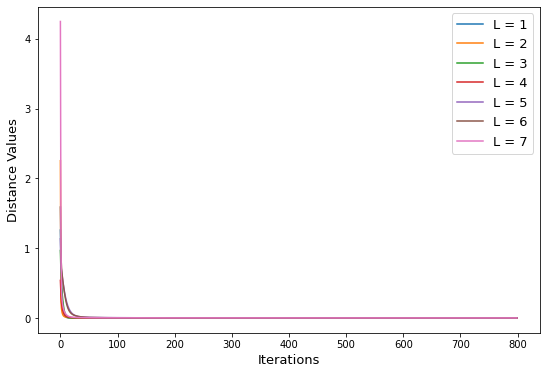

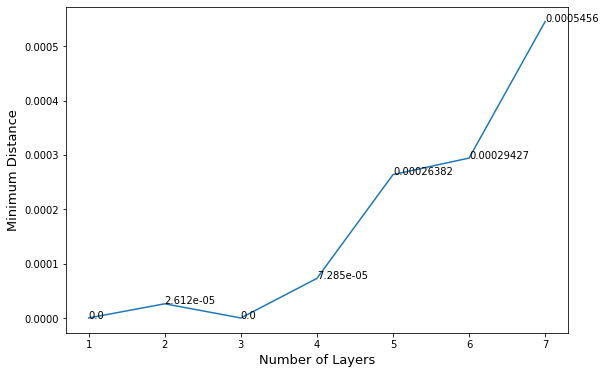

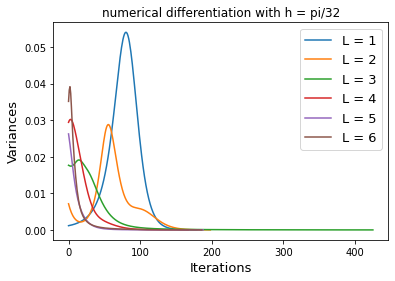

In [ ]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,8):
  with open('/content/mydrive/model1_layer_barren{}'.format(l)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  min_e .append(evalues[len(evalues)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 8), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()


for l in range(1,7):
  with open('/content/mydrive/model1_variance_barren{}'.format(l)) as f:
      variances  = f.read().splitlines()
  variances = [float(i) for i in variances]
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(variances,label = label)
plt.title('numerical differentiation with h = pi/32')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Variances", fontsize=13)
plt.legend(fontsize=13)
plt.show()

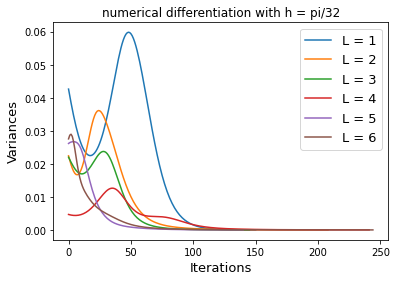

In [ ]:

for l in range(1,7):
  with open('/content/mydrive/model1_variance_barren{}'.format(l)) as f:
      variances  = f.read().splitlines()
  variances = [float(i) for i in variances]
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(variances,label = label)
plt.title('numerical differentiation with h = pi/32')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Variances", fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [ ]:
list_of_e =[]
types = 1
distance_type = 3
print(target_state)
for l in range(1,L+1):
  print('***** Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) 
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
  eValues = []
  variances = []
  for i in range(number_of_iteration):
    learning_rate = lr0/(1 + (i//lr_increase))
    params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320, distance_type = distance_type)
    #grads_variance = np.var(params_grads)
    #variances.append(grads_variance)

    #if grads_variance < 0.00001:
    #  print('Training stopped after', i, 'iterations. Model reached the barren plateau.')
    #  break

    params = update_params(params, params_grads,learning_rate)
    
    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state,distance_type)
    eValues.append(e)

    if i % print_step == 0:
      print('Iteration Number:', i, ', Distance:', e)
  print('---Training qnn with ', l, ' layers finished.','Final distance =', e,'.')
  print(' State approximation: ', approximation)
  np.savetxt('/content/mydrive/model1_layer_barren{}'.format(l), eValues, delimiter='\n')
  #np.savetxt('/content/mydrive/model1_variance_barren{}'.format(l), variances, delimiter='\n ')
  list_of_e.append(eValues)
print('Training finished.')

<tf.RaggedTensor [[8.351871720877864e-23j, (8.351871720877864e-23-1.910685253406468e-15j), (1.910685676922942e-15+8.351871720877864e-23j), (4.371138828673793e-08+3.82137093032941e-15j), (-8.351871720877864e-23-3.650719075574761e-30j), (1.910685253406468e-15+1.670374217957828e-22j), (-1.6703744703933177e-22+1.910685676922942e-15j), (-5.732056607252352e-15+4.371138828673793e-08j), (1.6703743441755729e-22-1.910685465164705e-15j), (-5.7320557602194046e-15+4.371138473402425e-08j), (-4.371139183945161e-08-5.732056607252352e-15j), (-1-1.7484555314695172e-07j), 0j, 0j, 0j, 0j]]>
***** Number of Layers: 1 *****
Iteration Number: 0 , Distance: 1.2600205
Iteration Number: 100 , Distance: 0.0
Iteration Number: 200 , Distance: 0.0
Iteration Number: 300 , Distance: 0.0
Iteration Number: 400 , Distance: 0.0
Iteration Number: 500 , Distance: 0.0
Iteration Number: 600 , Distance: 0.0
Iteration Number: 700 , Distance: 0.0
---Training qnn with  1  layers finished. Final distance = 0.0 .
 State approximat

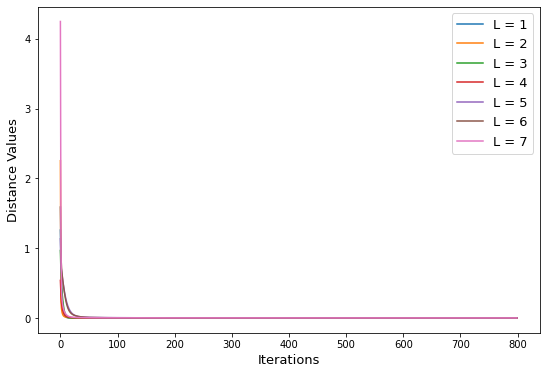

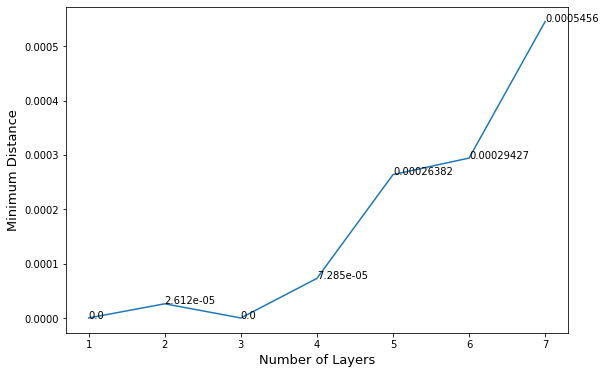

In [ ]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,8):
  with open('/content/mydrive/model1_layer_barren{}'.format(l)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  min_e .append(evalues[len(evalues)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 8), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()

## Training The QNNs
In the following, 10 QNNs, having 1 to 10 layers, are trained, with learning rate 0.01 and 1000 iterations.


In [ ]:
L = 10
learning_rate = 0.01
number_of_iteration = 1000
print_step = 100

In [ ]:
list_of_e =[]
types = 1
for l in range(1,L+1):
  print('***** Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) 
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
  eValues = []
  for i in range(number_of_iteration):
    params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320)
    params = update_params(params, params_grads,learning_rate)

    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state)
    eValues.append(e[0][0].numpy())

    if i % print_step == 0:
      print('Iteration Number:', i, ', Distance:', e[0][0].numpy())
  print('---Training qnn with ', l, ' layers finished.','Final distance =', e[0][0].numpy(),'.')
  np.savetxt('/content/mydrive/model1_layer_{}'.format(l), eValues, delimiter='\n')
  np.savetxt('/content/mydrive/model1_params_{}'.format(l), params, delimiter='\n ')
  list_of_e.append(eValues)
print('Training finished.')

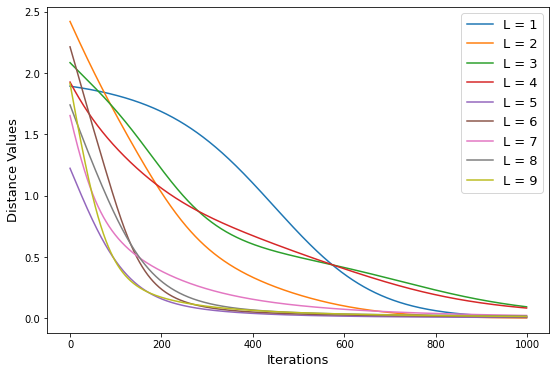

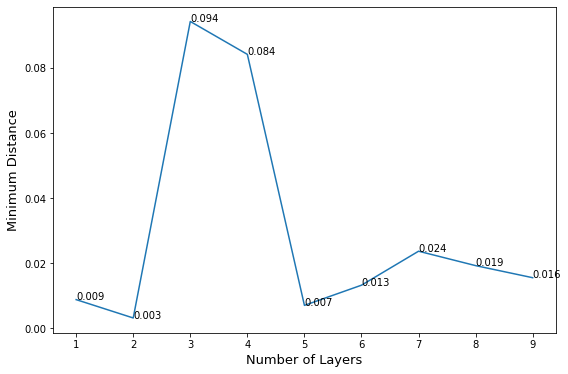

In [ ]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,10):
  with open('/content/mydrive/layer_{}'.format(l)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  min_e .append(evalues[len(evalues)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 3), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()

In the plots shown above, one can see the convergence rate of the models to the found optimum value. However, it seems that the random initialization of paramters affects the results and in some QNNs the training process reached the local optimum, that can be a result of [barren plateaus](https://www.nature.com/articles/s41467-018-07090-4). In the following part, learning rate is increased to 0.1 and each QNN model is trained in 5 rounds and the results are calculated by averaging out over these 5 rounds.

In [ ]:
L = 10
learning_rate = 0.1
number_of_iteration = 800
print_step = 100

In [ ]:
list_of_e =[]

types = 1
print('########## QNN Type', types, '##########')
for l in range(1,L+1):
  print('***** QNN Type', types,', Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  minValues = []
  for round in range(1,6):
    print( '-Training Round ', round, ':')
    params = tf.random.uniform(shape = (1,types*8*l), minval=0, maxval=2*np.pi) 
    params_names = sympy.symbols(['theta_{}'.format(n) for n in range(types*8*l)])
    eValues = []
    for i in range(number_of_iteration):
      params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320)
      params = update_params(params, params_grads,learning_rate)

      approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
      e = states_distance(approximation,target_state)
      eValues.append(e[0][0].numpy())

      if i % print_step == 0:
        print('  Iteration Number:', i, ', Distance:', e[0][0].numpy())
    np.savetxt('/content/mydrive/model{}_layer_{}_lr0.1_round{}'.format(types,l,round), eValues, delimiter='\n')
    np.savetxt('/content/mydrive/model{}_params_{}_lr0.1_round{}'.format(types,l,round), params, delimiter='\n ')
    print( '-Training Round ', round, ' finished. Final Minimum Distance =', e[0][0].numpy())
    minValues.append(e[0][0].numpy())

  print('---Training qnn with', l, 'layers finished. Mean of Minimum Distance in 5 rounds =', np.mean(minValues))

print('Training finished.')

########## QNN Type 1 ##########
***** QNN Type 1 , Number of Layers: 1 *****
-Training Round  1 :
  Iteration Number: 0 , Distance: 0.6295331
  Iteration Number: 100 , Distance: 2.7619508e-05
  Iteration Number: 200 , Distance: 9.522932e-10
  Iteration Number: 300 , Distance: 1.3103496e-11
  Iteration Number: 400 , Distance: 1.3103496e-11
  Iteration Number: 500 , Distance: 1.3103496e-11
  Iteration Number: 600 , Distance: 1.3103496e-11
  Iteration Number: 700 , Distance: 1.3103496e-11
-Training Round  1  finished. Final Minimum Distance = 1.3103496e-11
-Training Round  2 :
  Iteration Number: 0 , Distance: 1.8724238
  Iteration Number: 100 , Distance: 0.02350403
  Iteration Number: 200 , Distance: 8.459991e-07
  Iteration Number: 300 , Distance: 2.9990822e-11
  Iteration Number: 400 , Distance: 7.764693e-12
  Iteration Number: 500 , Distance: 7.7646015e-12
  Iteration Number: 600 , Distance: 7.7646015e-12
  Iteration Number: 700 , Distance: 7.7646015e-12
-Training Round  2  finished.

being too time consuming, I stopped training for more than 6 layers.
In the following, the results, saved in files in my google drive, are shown in plots. The plots are gained from averaging over 5 rounds for each QNN with 1 to 6 layers.

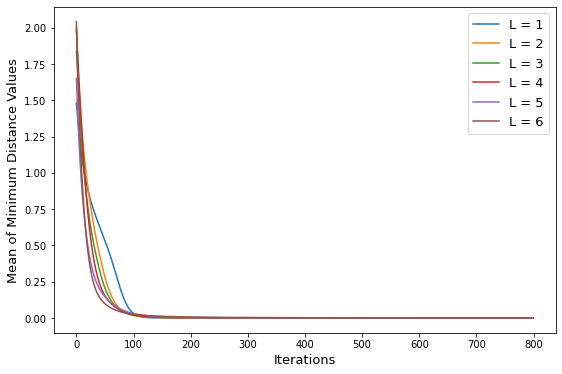

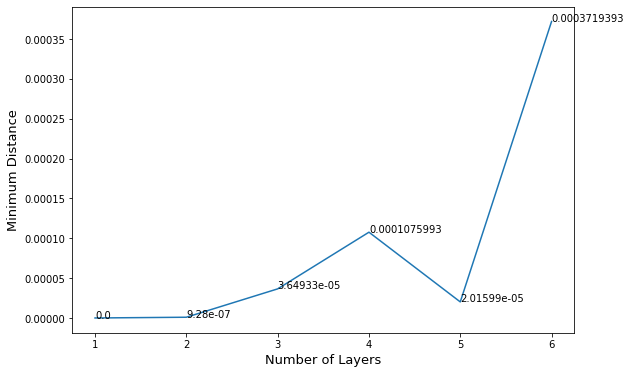

In [ ]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,7):
  averged_e = np.zeros((number_of_iteration,), dtype=float)
  for round in range(1,6):
    with open('/content/mydrive/model1_layer_{}_lr0.1_round{}'.format(l,round)) as f:
        evalues  = f.read().splitlines()
    averged_e += [float(i) for i in evalues]

  averged_e = averged_e/5
  min_e .append(averged_e[len(averged_e)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
    #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(averged_e,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Mean of Minimum Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 10), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()

Comparing the results of this training process with the previous one shows that the initial values for paramters play a significant role in the optimum value the models reach, due to [barren plateaus](https://www.nature.com/articles/s41467-018-07090-4) phenomenon.

According to [Sim et al.'s paper](https://arxiv.org/pdf/1905.10876.pdf), *a  major challenge in developing and scaling up variational hybrid quantum classical algorithms is the “barren plateau” phenomenon. It is shown that the expectation value of the gradient of the objective function rapidly approaches zero with increasing system size when the output states are randomly drawn from an approximate 2-design. This shows that expressible circuits must be used with care. In particular, with an expressible circuit, choosing a random starting point for a VQE optimization is not a reasonable approach.*

 Therefore in the following training process, I stop training when the model reach the barren plateau, the variance of gradient is very small.

In [ ]:
list_of_e =[]
types = 1
distance_type = 3
print(target_state)
for l in range(1,L+1):
  print('***** Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) 
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
  eValues = []
  variances = []
  for i in range(number_of_iteration):
    learning_rate = lr0/(1 + (i//lr_increase))
    params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320, distance_type = distance_type)
    grads_variance = np.var(params_grads)
    variances.append(grads_variance)

    params = update_params(params, params_grads,learning_rate)
    
    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state,distance_type)
    eValues.append(e)

  np.savetxt('/content/mydrive/model1_layer_barren{}'.format(l), eValues, delimiter='\n')
  np.savetxt('/content/mydrive/model1_variance_barren{}'.format(l), variances, delimiter='\n ')
  list_of_e.append(eValues)

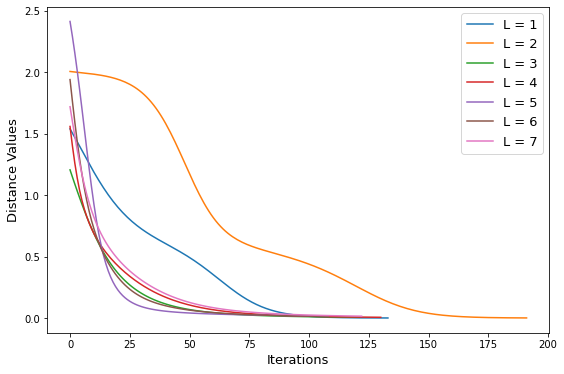

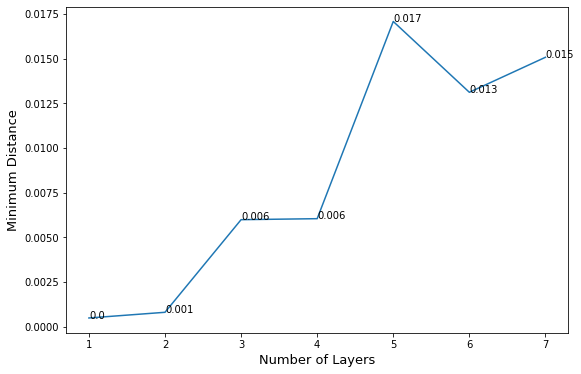

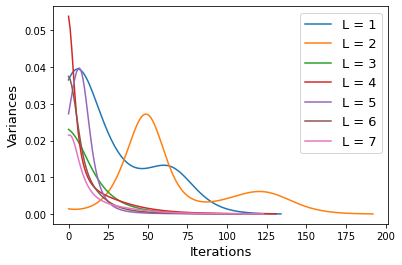

In [ ]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,8):
  with open('/content/mydrive/model1_layer_barren{}'.format(l)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  min_e .append(evalues[len(evalues)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 3), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()

for l in range(1,8):
  with open('/content/mydrive/model1_variance_barren{}'.format(l)) as f:
      variances  = f.read().splitlines()
  variances = [float(i) for i in variances]
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(variances,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Variances", fontsize=13)
plt.legend(fontsize=13)
plt.show()

Noticing the variance plot, one can see that the variance of gradients for QNNs with 1 and 2 layers converge to zero with slower rate, so they reach the barren plateau phenomenon, and it can be the reason for getting better results from QNNs with this lower numbers of layers.

In the following part, parameter shift rule for partial derivatives, instead of numerical method.

In [ ]:
list_of_e =[]
types = 1
for l in range(1,L+1):
  print('***** Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) 
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
  eValues = []
  variances = []
  for i in range(number_of_iteration):
    params_grads = custom_gradient(params, target_state,parameter_shift = True, h = np.pi/320)
    grads_variance = np.var(params_grads)
    variances.append(grads_variance)

    if grads_variance < 0.00005:
      print('Training stopped. Model reached the barren plateau.')
      break

    params = update_params(params, params_grads,learning_rate)
    
    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state)
    eValues.append(e[0][0].numpy())

    if i % print_step == 0:
      print('Iteration Number:', i, ', Distance:', e[0][0].numpy())
  print('---Training qnn with ', l, ' layers finished.','Final distance =', e[0][0].numpy(),'.')
  np.savetxt('/content/mydrive/model1_layer_barren{}_paramshift'.format(l), eValues, delimiter='\n')
  np.savetxt('/content/mydrive/model1_variance_barren{}_paramshift'.format(l), variances, delimiter='\n ')
  list_of_e.append(eValues)
print('Training finished.')

***** Number of Layers: 1 *****
Iteration Number: 0 , Distance: 1.9494478
Training stopped. Model reached the barren plateau.
---Training qnn with  1  layers finished. Final distance = 0.00022219282 .
***** Number of Layers: 2 *****
Iteration Number: 0 , Distance: 2.767926
Iteration Number: 100 , Distance: 0.0067698527
Training stopped. Model reached the barren plateau.
---Training qnn with  2  layers finished. Final distance = 0.0022604465 .
***** Number of Layers: 3 *****
Iteration Number: 0 , Distance: 0.75599384
Training stopped. Model reached the barren plateau.
---Training qnn with  3  layers finished. Final distance = 0.0021937918 .
***** Number of Layers: 4 *****
Iteration Number: 0 , Distance: 2.0713913
Training stopped. Model reached the barren plateau.
---Training qnn with  4  layers finished. Final distance = 0.00563058 .
***** Number of Layers: 5 *****
Iteration Number: 0 , Distance: 2.4399414
Training stopped. Model reached the barren plateau.
---Training qnn with  5  lay

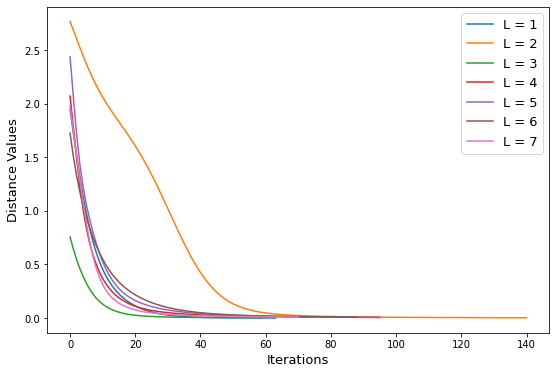

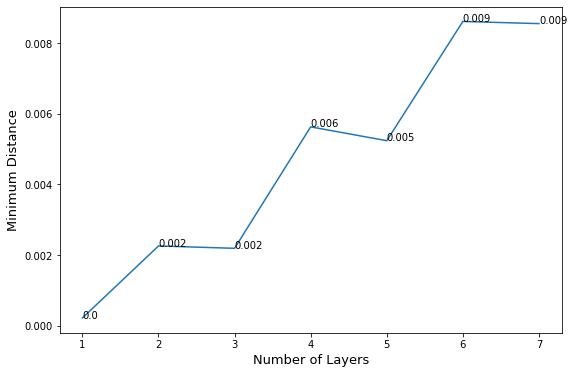

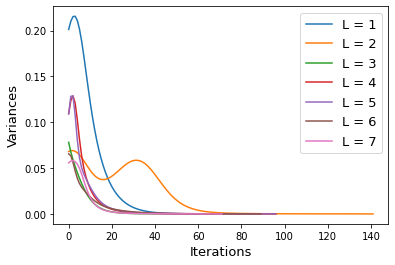

In [ ]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,8):
  with open('/content/mydrive/model1_layer_barren{}_paramshift'.format(l)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  min_e .append(evalues[len(evalues)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 3), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()

for l in range(1,8):
  with open('/content/mydrive/model1_variance_barren{}_paramshift'.format(l)) as f:
      variances  = f.read().splitlines()
  variances = [float(i) for i in variances]
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(variances,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Variances", fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [ ]:
for l in range(1,8):
  with open('/content/mydrive/model1_variance_barren{}'.format(l)) as f:
      variances  = f.read().splitlines()
  variances = [float(i) for i in variances]
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(variances,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Variances", fontsize=13)
plt.legend(fontsize=13)
plt.show()

## Bonus part
Now let's see what happens if other kinds of circuits used for implementing the QNN. The following circuit is replaced with the previous design for implementing each layer of the QNN, based on [Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms](https://arxiv.org/pdf/1905.10876.pdf).

<img src = "Figures/c2.png" style = "width:400px"/><figcaption><center>Figure 3<figcaption>

So I change *generate_even_block* and *generate_odd_block* functions by adding one extra arguments *types* that determine which type of circuits is generated. Also, the default value 1  is assigned for *types*. 

Let's see the new model:

In [ ]:
l=1
types = 2 
qnn = generate_qnn(l,types = types)
print(qnn)

# Defining and Initializing the parameters:
params = tf.random.uniform(shape = (1,16*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
print('Parameters:\n', params)
params_names = sympy.symbols(['theta_{}'.format(n) for n in range(16*l)])

# Calculating the state vector:
state_layer = tfq.layers.State()
state = state_layer(qnn, symbol_names=params_names, symbol_values=params)
print('\nState Vector:\n', state)

(0, 0): ───Ry(theta_0)───X───────────────────────────────────@───────────Ry(theta_8)─────────────────@────────────X─────────────────────────
                         │                                   │                                       │            │
(0, 1): ───Ry(theta_1)───┼───────────────────────@───────────X^theta_7───Ry(theta_9)─────────────────┼────────────@^theta_14───X────────────
                         │                       │                                                   │                         │
(0, 2): ───Ry(theta_2)───┼───────────@───────────X^theta_6───────────────Ry(theta_10)───X────────────┼─────────────────────────@^theta_15───
                         │           │                                                  │            │
(0, 3): ───Ry(theta_3)───@^theta_4───X^theta_5───────────────────────────Ry(theta_11)───@^theta_12───X^theta_13─────────────────────────────
Parameters:
 tf.Tensor(
[[5.2667794  4.9258394  0.54665446 6.097768   1.0340236  4.74064

In [ ]:
np.savetxt('/content/mydrive/model2_params_{}'.format(l), params, delimiter='\n ')

In [ ]:
 with open('/content/mydrive/model2_params_1') as f:
    x  = f.read().splitlines()
x = [[float(i) for i in x]]

In [ ]:
state = state_layer(qnn, symbol_names=params_names, symbol_values=x)
e = states_distance(state,target_state)
print(e)

tf.Tensor([[2.228401]], shape=(1, 1), dtype=float32)


Now, let's see how this new layers get trained. This model has twice more paramterized gate, and more parameters to train, consequently. Therefore, it is more time consuming than the previous model. Hence, instead of checking QNN with at most 10 layers, I check QNN with at most 6 layers.

In [ ]:
L = 6
learning_rate = 0.01
number_of_iteration = 1000
print_step = 100

In [ ]:
list_of_e =[]
types = 2
for l in range(1,L+1):
  print('***** Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,16*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(16*l)])
  eValues = []
  for i in range(number_of_iteration):
    params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320)
    params = update_params(params, params_grads,learning_rate)

    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state)
    eValues.append(e[0][0].numpy())

    if i % print_step == 0:
      print('Iteration Number:', i, ', Distance:', e[0][0].numpy())
  print('---Training qnn with ', l, ' layers finished.','Final distance =', e[0][0].numpy(),'.')
  np.savetxt('/content/mydrive/model2_layer_{}'.format(l), eValues, delimiter='\n')
  np.savetxt('/content/mydrive/model2_params_{}'.format(l), params, delimiter='\n ')
  list_of_e.append(eValues)
print('Training finished.')

***** Number of Layers: 1 *****
Iteration Number: 0 , Distance: 2.2417047
Iteration Number: 100 , Distance: 1.2201717
Iteration Number: 200 , Distance: 0.8017386
Iteration Number: 300 , Distance: 0.59037983
Iteration Number: 400 , Distance: 0.43708014
Iteration Number: 500 , Distance: 0.28918684
Iteration Number: 600 , Distance: 0.15915452
Iteration Number: 700 , Distance: 0.07263423
Iteration Number: 800 , Distance: 0.028994339
Iteration Number: 900 , Distance: 0.010807085
---Training qnn with  1  layers finished. Final distance = 0.0039653415 .
***** Number of Layers: 2 *****
Iteration Number: 0 , Distance: 2.0078611
Iteration Number: 100 , Distance: 0.28152537
Iteration Number: 200 , Distance: 0.1718893
Iteration Number: 300 , Distance: 0.120091274
Iteration Number: 400 , Distance: 0.08401838
Iteration Number: 500 , Distance: 0.058970433
Iteration Number: 600 , Distance: 0.041928664
Iteration Number: 700 , Distance: 0.03062285
Iteration Number: 800 , Distance: 0.023262916
Iteration 

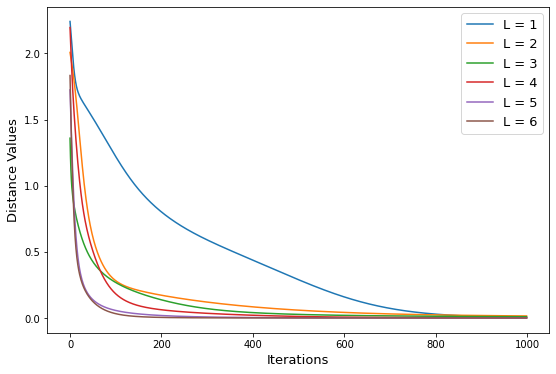

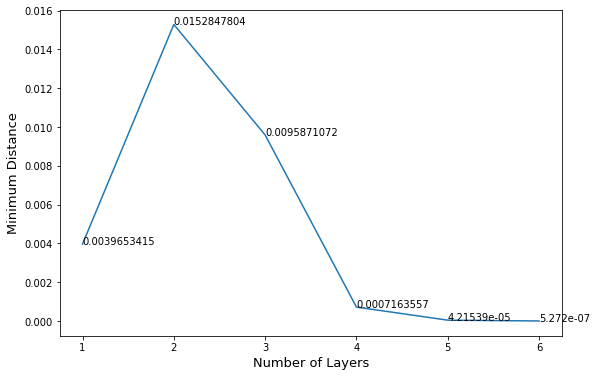

In [ ]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,L+1):
  with open('/content/mydrive/model2_layer_{}'.format(l)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  min_e .append(evalues[len(evalues)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 10), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()

In [ ]:
L = 6
learning_rate = 0.1
number_of_iteration = 500
print_step = 100

In [ ]:
list_of_e =[]

types = 2
print('########## QNN Type', types, '##########')
for l in range(1,L+1):
  print('***** QNN Type', types,', Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  minValues = []
  for round in range(1,4):
    print( '-Training Round ', round, ':')
    params = tf.random.uniform(shape = (1,16*l), minval=0, maxval=2*np.pi) 
    params_names = sympy.symbols(['theta_{}'.format(n) for n in range(16*l)])
    eValues = []
    for i in range(number_of_iteration):
      params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320)
      params = update_params(params, params_grads,learning_rate)

      approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
      e = states_distance(approximation,target_state)
      eValues.append(e[0][0].numpy())

      if i % print_step == 0:
        print('  Iteration Number:', i, ', Distance:', e[0][0].numpy())
    np.savetxt('/content/mydrive/model{}_layer_{}_lr0.1_round{}'.format(types,l,round), eValues, delimiter='\n')
    np.savetxt('/content/mydrive/model{}_params_{}_lr0.1_round{}'.format(types,l,round), params, delimiter='\n ')
    print( '-Training Round ', round, ' finished. Final Minimum Distance =', e[0][0].numpy())
    minValues.append(e[0][0].numpy())

  print('---Training qnn with', l, 'layers finished. Mean of Minimum Distance in 3 rounds =', np.mean(minValues))
  
print('Training finished.')

########## QNN Type 2 ##########
***** QNN Type 2 , Number of Layers: 1 *****
-Training Round  1 :
  Iteration Number: 0 , Distance: 1.7933235
  Iteration Number: 100 , Distance: 0.0008340365
  Iteration Number: 200 , Distance: 9.873538e-07
  Iteration Number: 300 , Distance: 9.549297e-09
  Iteration Number: 400 , Distance: 1.0457199e-10
-Training Round  1  finished. Final Minimum Distance = 1.073624e-11
-Training Round  2 :
  Iteration Number: 0 , Distance: 1.6489255
  Iteration Number: 100 , Distance: 0.0060326615
  Iteration Number: 200 , Distance: 0.024269503
  Iteration Number: 300 , Distance: 0.0005519236
  Iteration Number: 400 , Distance: 0.00015875409
-Training Round  2  finished. Final Minimum Distance = 7.768302e-05
-Training Round  3 :
  Iteration Number: 0 , Distance: 1.878262
  Iteration Number: 100 , Distance: 0.611331
  Iteration Number: 200 , Distance: 0.5008111
  Iteration Number: 300 , Distance: 0.012378938
  Iteration Number: 400 , Distance: 0.00034098089
-Training 

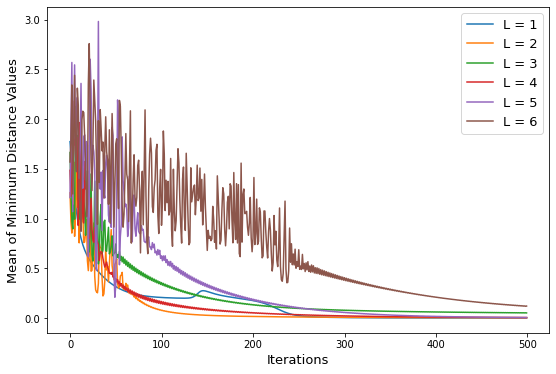

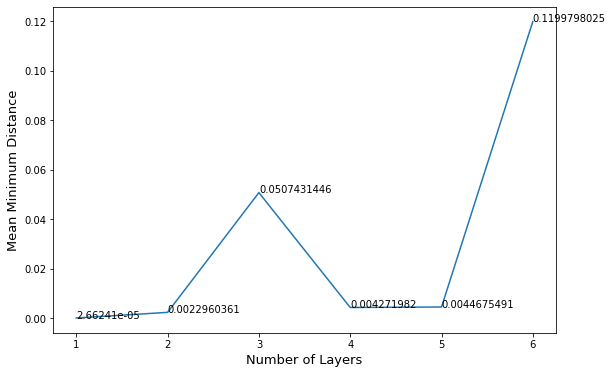

In [ ]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,7):
  averged_e = np.zeros((number_of_iteration,), dtype=float)
  for round in range(1,4):
    with open('/content/mydrive/model2_layer_{}_lr0.1_round{}'.format(l,round)) as f:
        evalues  = f.read().splitlines()
    averged_e += [float(i) for i in evalues]

  averged_e = averged_e/3
  min_e .append(averged_e[len(averged_e)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
    #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(averged_e,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Mean of Minimum Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 10), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Mean Minimum Distance", fontsize=13)
plt.show()

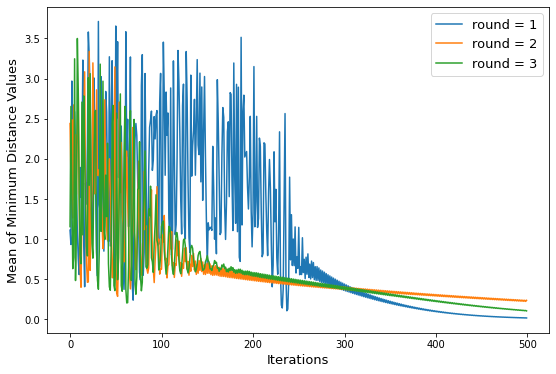

In [ ]:
plt.figure(figsize=(9, 6))
number_of_L = []
l = 6
for round in range(1,4):
  label =[]
  with open('/content/mydrive/model2_layer_{}_lr0.1_round{}'.format(l,round)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  label='round = {}'.format(round)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Mean of Minimum Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()

## Different Setting
Let us try another setting, which is more realistic and experimentally feasible than the previous setting. Therefore, instead of calculating the whole state and and its gradient, let us calculate the expectation value of target state and output of QNNs by using Pauli Z.


In [29]:
l=1
qnn = generate_qnn(l)
print(qnn)

# Defining and Initializing the parameters:
params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32) #tf.zeros([1,8*l ], tf.float32)
print('Parameters:\n', params)
params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])

                                               ┌──┐
(0, 0): ───Rx(theta_0)───Rz(theta_4)───@───@────@─────────────
                                       │   │    │
(0, 1): ───Rx(theta_1)───Rz(theta_5)───@───┼────┼@────@───────
                                           │    ││    │
(0, 2): ───Rx(theta_2)───Rz(theta_6)───────@────┼@────┼───@───
                                                │     │   │
(0, 3): ───Rx(theta_3)───Rz(theta_7)────────────@─────@───@───
                                               └──┘
Parameters:
 tf.Tensor(
[[1.2053764 5.0500984 4.0883083 1.8839891 3.5121539 2.9870644 6.089727
  0.8598   ]], shape=(1, 8), dtype=float32)


In [7]:
qubits = cirq.GridQubit.rect(1, 9)


In [8]:
""" cirq.testing.random_circuit is used to generate a random state. The loop is for making sure that all
    the four qubits are involved in random generation."""

target_circuit = cirq.testing.random_circuit(qubits = qubits[4:8],n_moments = np.random.randint(low=1,high=5),\
                                                                op_density = 0.99999999)

print(target_circuit)

           ┌──┐
(0, 4): ────Z─────

(0, 5): ─────@────
             │
(0, 6): ────H┼────
             │
(0, 7): ─────@────
           └──┘


In [31]:
cop_target = target_circuit

In [32]:
print(tfq.layers.State()(cop_target))

Instructions for updating:
reduction_indices is deprecated, use axis instead
<tf.RaggedTensor [[(0.7071067690849304-1.2802768623032534e-08j), 0j, (0.7071067690849304+3.0908619663705394e-08j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]]>


In [33]:
state_layer = tfq.layers.State()
params = [[ 6.2826700e+00, -4.9439946e-04,  4.7118464e+00, -5.0401338e-04,
   5.0808892e+00,  2.7888281e+00,  4.7117438e+00,  6.7661673e-01]]
print(state_layer(qnn, symbol_names=params_names, symbol_values=params))

<tf.RaggedTensor [[(0.6650557518005371-0.23964403569698334j), (-5.7858575019054115e-05+0.00016848984523676336j), (0.66526198387146-0.240203395485878j), (5.7781231589615345e-05-0.0001686186296865344j), (-0.00011239088780712336-0.00013381161261349916j), (-4.402732045605262e-08+9.678698953408116e-10j), (0.00011253823322476819+0.00013381171447690576j), (-4.4050587177935085e-08+9.968034175855678e-10j), (0.0001820848701754585+4.129087756155059e-06j), (2.9544168000938953e-08-3.512557356089019e-08j), (-0.00018218632612843066-4.013814759673551e-06j), (2.9537531531786954e-08-3.516369417866372e-08j), (1.4592996144813242e-08+4.2592326110479917e-08j), (-1.0671562591935135e-11-3.8537185595433066e-12j), (1.4628400712979328e-08+4.2606018268998014e-08j), (1.0679841559724235e-11+3.848923783855707e-12j)]]>


In [6]:
def SwapTest():
  return cirq.Circuit(
      cirq.H(qubits[8]),
      cirq.decompose(cirq.CSwapGate().on(qubits[8], qubits[0], qubits[4])), 
      cirq.decompose(cirq.CSwapGate().on(qubits[8], qubits[1], qubits[5])),
      cirq.decompose(cirq.CSwapGate().on(qubits[8], qubits[2], qubits[6])),
      cirq.decompose(cirq.CSwapGate().on(qubits[8], qubits[3], qubits[7])),
      cirq.H(qubits[8])
  )

In [21]:
pqc = generate_qnn(2) + target_circuit + SwapTest()
print(pqc)

                                               ┌──┐                                                 ┌──┐           ┌──┐                                                                                            ┌───────┐                                ┌───────┐                        ┌─────┐                         ┌───────┐                         ┌──────┐            ┌─────┐                                                              ┌───────┐                                ┌───────┐                        ┌─────┐                         ┌───────┐                         ┌──────┐            ┌─────┐                                                              ┌───────┐                                ┌───────┐                        ┌─────┐                         ┌───────┐                         ┌──────┐            ┌─────┐                                                              ┌───────┐                                ┌───────┐                        ┌─────┐                     

In [9]:
def state_difference(measure_result):
  return 1 - measure_result

In [25]:
L = 7
lr0 = 0.4
number_of_iteration = 1000
print_step = 100
lr_increase = 50
learning_rate = 0.1


In [34]:
losses = []
types =1

for l in range(1,L+1):
  losses = []
  print('***** QNN Type', types,', Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
  pqc = qnn + target_circuit + SwapTest()

  qubit_8_expectation = tfq.layers.ControlledPQC(pqc,[cirq.PauliString(cirq.Z(qubits[8]))])
  for i in range(number_of_iteration):

    learning_rate = lr0/(1 + (i//lr_increase))
    with tf.GradientTape() as tape:
        tape.watch(params)

        expectation8 = qubit_8_expectation([tfq.convert_to_tensor([cirq.Circuit()]),params])
        distance = state_difference(expectation8)
    
    losses.append(distance[0][0].numpy())
    
    params_gradient = tape.gradient(distance, params)
    params = update_params(params, params_gradient,learning_rate)

    if i % print_step == 0:
      print('  Iteration Number:', i, ', Distance:', distance[0][0].numpy())
  np.savetxt('/content/mydrive/model1_design2_l{}'.format(l), losses, delimiter='\n')
  print('---Training qnn with', l, 'layers finished. Minimum distance =',  distance[0][0].numpy())
  
print('Training finished.')

***** QNN Type 1 , Number of Layers: 1 *****
  Iteration Number: 0 , Distance: 0.8026464
  Iteration Number: 100 , Distance: 5.1259995e-06
  Iteration Number: 200 , Distance: 5.1259995e-06
  Iteration Number: 300 , Distance: 5.2452087e-06
  Iteration Number: 400 , Distance: 5.2452087e-06
  Iteration Number: 500 , Distance: 4.887581e-06
  Iteration Number: 600 , Distance: 5.543232e-06
  Iteration Number: 700 , Distance: 5.1259995e-06
  Iteration Number: 800 , Distance: 5.3048134e-06
  Iteration Number: 900 , Distance: 4.887581e-06
---Training qnn with 1 layers finished. Minimum distance = 5.4836273e-06
***** QNN Type 1 , Number of Layers: 2 *****
  Iteration Number: 0 , Distance: 0.64055276
  Iteration Number: 100 , Distance: 0.0010008216
  Iteration Number: 200 , Distance: 0.0004863739
  Iteration Number: 300 , Distance: 0.00033706427
  Iteration Number: 400 , Distance: 0.00026589632
  Iteration Number: 500 , Distance: 0.000223279
  Iteration Number: 600 , Distance: 0.00019407272
  Ite

In [15]:
print(distance[0][0].numpy())

5.1259995e-06


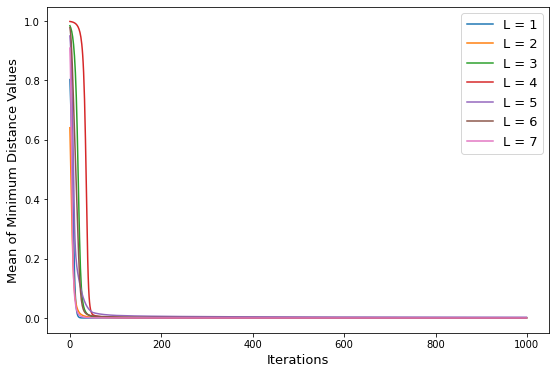

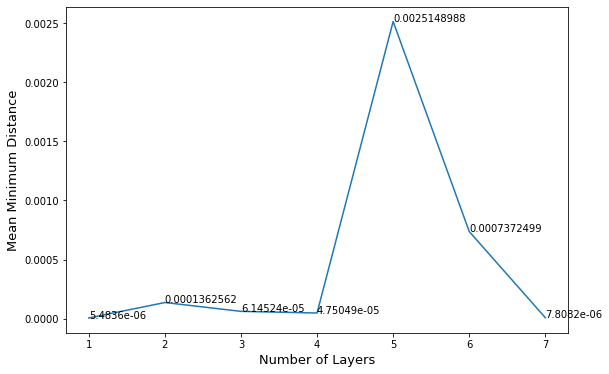

In [40]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,L+1):
  averged_e = np.zeros((number_of_iteration,), dtype=float)
  for round in range(1,4):
    with open('/content/mydrive/model1_design2_l{}'.format(l)) as f:
        evalues  = f.read().splitlines()
    averged_e += [float(i) for i in evalues]

  averged_e = averged_e/3
  min_e .append(averged_e[len(averged_e)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
    #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(averged_e,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Mean of Minimum Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 10), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Mean Minimum Distance", fontsize=13)
plt.show()

TypeError: ignored